In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from konlpy.tag import Okt
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./src/네이버종토방댓글_카카오_15000.csv')
df

,날짜,댓글,조회수,좋아요,싫어요
0,2022-05-03,개미들 조련하는법,26,1,0
1,2022-05-03,6만원,38,1,0
2,2022-05-03,카카오는 끝물입니다 사실상,72,2,2
3,2022-05-03,안티 살발하다,34,2,0
4,2022-05-03,이런 호로개미지옥탕을 만드신,58,3,1
...,...,...,...,...,...
299995,2017-10-18,어차피 또 폭등할텐데 떨필요있나 기회주면...,795,15,3
299996,2017-10-18,오늘 물렸다고 생각하는 사람들은 도대체 ...,961,3,2
299997,2017-10-18,내일도,618,5,1
299998,2017-10-18,아마존 per는 300?,745,4,1


In [3]:
df = df[df['댓글'] != 'error']
df = df.dropna()
df['한글댓글'] = df['댓글'].str.replace('\[삭제된 게시물의 답글\]',' ')
df['한글댓글'] = df['한글댓글'].str.replace('답글:',' ')
df['한글댓글'] = df['한글댓글'].str.replace('[^가-힣]',' ').str.replace(' +',' ').str.strip()
df = df[df['한글댓글'] != '']
df = df.reset_index(drop=True)
df

,날짜,댓글,조회수,좋아요,싫어요,한글댓글
0,2022-05-03,개미들 조련하는법,26,1,0,개미들 조련하는법
1,2022-05-03,6만원,38,1,0,만원
2,2022-05-03,카카오는 끝물입니다 사실상,72,2,2,카카오는 끝물입니다 사실상
3,2022-05-03,안티 살발하다,34,2,0,안티 살발하다
4,2022-05-03,이런 호로개미지옥탕을 만드신,58,3,1,이런 호로개미지옥탕을 만드신
...,...,...,...,...,...,...
295849,2017-10-18,어차피 또 폭등할텐데 떨필요있나 기회주면...,795,15,3,어차피 또 폭등할텐데 떨필요있나 기회주면
295850,2017-10-18,오늘 물렸다고 생각하는 사람들은 도대체 ...,961,3,2,오늘 물렸다고 생각하는 사람들은 도대체
295851,2017-10-18,내일도,618,5,1,내일도
295852,2017-10-18,아마존 per는 300?,745,4,1,아마존 는


In [4]:
stop_word = ['이','들','가','은','에','는','만','의','도','을','아','다','한','주','명','층','자','수','두','성','잘','제','못','중'
             ,'를','로','안','고','나','내','네','때','시','전','대','하','왜','라','게','님','형','점','일','야','적','과','니','글'
             ,'너','날','문','더','요','지','말','위','애','년','좀','거','조','뭐','삼','면','인','장','억','월','냐','것','오','해'
             ,'우','석','외','분','그','서','당','와','저','재','기','또','매','윤','난','후','차','간','여','열','공','액','빨','천'
             ,'앞','총','카','랑','박','단','선','검','양','구','번','세','방','앞','엔'
             
             ,'까지','부터','인데','에서','하다','되다','으로','에게','돼다','한테','그냥','이나','내다','이다','있다','이네'
             ,'하고','보다','대다','없다','너무','이제','다시','같다'
             
             ,'아니다','그렇다','어떻다','안되다','아직도','이렇다'
             ]

neutral_word = ['카카오','주식','윤석열','개미','전자','이재명','삼성','삼전','대통령','국민','주가','민주당','문재인','사람'
                ,'속보','미국','한국','기업','전쟁','정치','주주','네이버','정권','죄명','나라','돈','만원','다음','시작'
                ,'러시아','코스피','재앙','대장동','윤석렬','프로','종가','대선','중국','정부','상장','좌파','코로나','생각'
                ,'안철수','평단','나스닥','증시','후보','김건희','대한민국','토론','투자','분할','시간','뉴스','우크라이나','당선'
                ,'회사','종목','국정원','낼','하나','개인','검찰','실적','청와대','보고','예상','적정','앵두','외인','기관'
                ,'외국인','세력','규제','상','물','배당','연기금','지지','금리','시장','선물','만주','김범수','푸틴','북한'
                ,'거래','반도체','선거','차트','딸','허경영','투표','전라도','세계','가격','지수','말씀','끝','배당금','빨갱이'
                ,'힘','수완','소리','목표','범수','보수','단타','여론조작','어제','내일','오늘','가다','오다','원','들다','짜다'
                ,'여기','알다','지금','이번','진짜','크다','이유'
                ,'우리','아직','역시','나다','나오다','잡다','맞다','주다','많다','살다','자다','모르다','많이'
                ,'받다','않다','치다','넘다','찍다','때문','이상','시키다','누가','언제','밉다','지다','찢다','끄다','갈다'
                ,'계속','추다','인들','주리다','개다','한번','차다','미치다','쓰다','만들다','뽑다','빨리','말다','이야','늘다']

In [5]:
okt = Okt()

tokenized_data = []
for i in range(df['한글댓글'].shape[0]):
    tokenized_sentence = okt.morphs(df['한글댓글'][i], stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stop_word] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)
    if i % 10000 == 0:
        print(f'{i}개 토큰화 완료')

0개 토큰화 완료
10000개 토큰화 완료
20000개 토큰화 완료
30000개 토큰화 완료
40000개 토큰화 완료
50000개 토큰화 완료
60000개 토큰화 완료
70000개 토큰화 완료
80000개 토큰화 완료
90000개 토큰화 완료
100000개 토큰화 완료
110000개 토큰화 완료
120000개 토큰화 완료
130000개 토큰화 완료
140000개 토큰화 완료
150000개 토큰화 완료
160000개 토큰화 완료
170000개 토큰화 완료
180000개 토큰화 완료
190000개 토큰화 완료
200000개 토큰화 완료
210000개 토큰화 완료
220000개 토큰화 완료
230000개 토큰화 완료
240000개 토큰화 완료
250000개 토큰화 완료
260000개 토큰화 완료
270000개 토큰화 완료
280000개 토큰화 완료
290000개 토큰화 완료


In [122]:
model = Word2Vec(sentences=tokenized_data, vector_size=100, window=5, min_count=10, workers=4, sg=1)
# vertor_size 차원수 : 보통 논문이나, 실험에서는 100~300 값으로 설정해 사용한다 (적당한 차원수 = 단어갯수 ** 0.25)
# window : 훈련시 앞 뒤로 고려하는 단어의 개수
# min_count : 최소 빈도수, 해당 빈도수보다 작게 등장한 단어의 경우 모델 학습에서 배제
# workers : 모델을 만들때, 스레드 개수 지정, 스레드가 많아질수록 모델 빌드 속도가 빨라진다.
# sg : 1 - skip-gram / 2 - CBOW
# - skip-gram : 해당 단어를 통해 주변단어를 예측
# - CBOW : 주변 단어를 통해 해당 단어를 예측

In [123]:
model.wv.vectors.shape

(6736, 100)

In [125]:
print(model.wv.most_similar('시발'))

[('징글징글', 0.9157857894897461), ('호로', 0.9056076407432556), ('씨발', 0.8628488779067993), ('전라', 0.8622013330459595), ('이개', 0.8604938387870789), ('짜증나다', 0.8532607555389404), ('백종원', 0.8500951528549194), ('빡치다', 0.8485503792762756), ('거지같다', 0.8477129340171814), ('아오', 0.8453037738800049)]


In [82]:
from sklearn.manifold import TSNE
model.wv.vectors

array([[-0.22788651,  0.45538786,  0.1587352 , ..., -0.40314886,
         0.20676424,  0.38954934],
       [-0.2310636 ,  0.38748065, -0.17156605, ..., -0.08408079,
        -0.33643478,  0.14101936],
       [ 0.06887176,  0.20551807, -0.12436582, ..., -0.13928647,
        -0.04072959,  0.1074951 ],
       ...,
       [-0.14238541,  0.20809753,  0.05678995, ..., -0.24630967,
         0.13629343,  0.06548037],
       [-0.11894551,  0.26339665,  0.10158405, ..., -0.1943253 ,
         0.04927699, -0.07715619],
       [-0.12227262,  0.2419107 ,  0.02382444, ..., -0.17924778,
         0.16008407,  0.06717506]], dtype=float32)

In [87]:
word_vectors = model.wv

vocabs = word_vectors.key_to_index
word_vectors_list = [word_vectors[v] for v in vocabs]

In [120]:
from sklearn.decomposition import PCA

sentences = tokenized_data[:100]
model = Word2Vec(sentences, vector_size=300, window=3, min_count=1, workers=1)

word_vectors = model.wv

vocabs = word_vectors.key_to_index
word_vectors_list = [word_vectors[v] for v in vocabs]

pca = PCA(n_components=2)   # 2개의 차원으로 축소
xys = pca.fit_transform(word_vectors_list)
xs = xys[:,0]
ys = xys[:,1]

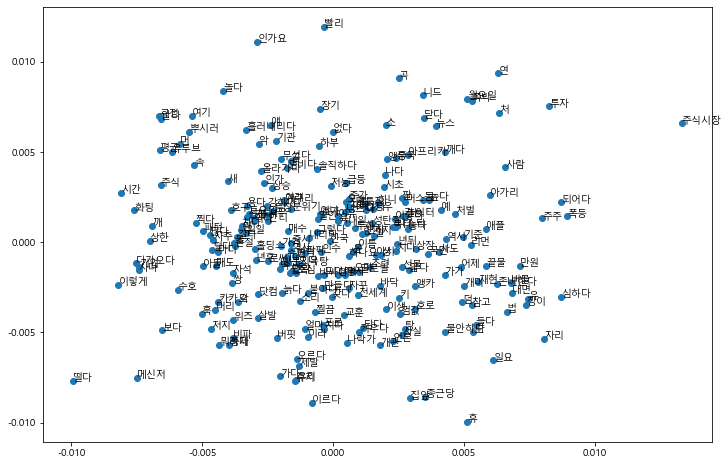

In [121]:
# 단어와 2차원 X축의 값, Y축으로 2차원 그래프를 그린다.

plt.rcParams['font.family'] = 'Malgun Gothic' # 인코딩 문제

plt.figure(figsize=(12, 8))
plt.scatter(xs, ys, marker = 'o')
for i,v in enumerate(vocabs):
    plt.annotate(v, xy=(xs[i], ys[i]))